# <center> 教学案例4：RAG技术实战
# <center> Part 1.RAG快速入门

## 一、RAG（Retrieval-Augmented Generation，检索增强生成）技术综述

&emsp;&emsp;RAG，Retrieval-Augmented Generation，也被称作检索增强生成技术，最早在 Facebook AI（Meta AI）在 2020 年发表的论文《Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks》（ https://arxiv.org/abs/2005.11401 ）中正式提出，这种方法的核心思想是借助一些文本检索策略，让大模型每次问答前都带入相关文本，以此来改善大模型回答时的准确性。这项技术刚发布时并未引发太大关注，而伴随2022年大模型技术大爆发，RAG技术才逐渐进入人们视野，并且由于早期大模型技术应用均已“知识库问答”为主，而RAG技术是最易上手、并且上限极高的技术，因此很快就成为了大模型技术人必备的技术之一。

### 1. RAG技术极简实现流程

&emsp;&emsp;时至今日，RAG技术已经是非常庞大的技术体系了，从简答的文档切分、存储、匹配，再到复杂的入GraphRAG（基于知识图谱的检索增强），以及复杂文档解析+多模态识别技术等等等等。

<center><img src="https://pictes.oss-cn-beijing.aliyuncs.com/LLM/rh5rzr.png" alt="image-20250708010422027" style="zoom:33%;" />

而对于初学者来说，为了更好的上手学习RAG技术，我们首先需要对RAG技术最简单的实现形式有个基础的了解。一个最简单的RAG技术实现流程如下所示：

<center><center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20231218182814731.png" alt="image-20231218182814731" style="zoom:33%;" /></center>

我们需要围绕给定的文档（往往是非常长的文档）先进行切分，然后将切分的文档转化为计算机能识别的形式，也就是将其转化为一个数值型向量（也被称为词向量），然后当用户询问问题的时候，我们再将用户的问题转化为词向量，并和段落文档的词向量进行相似度匹配，借此找出和当前用户问题最相关的原始文档片段，然后将用户的问题和匹配的到的原文片段都带入大模型，进行最终的问答。由此便可实现一次完整的文档检索增强执行流程。

&emsp;&emsp;具体执行过程如下所示：

<center><center><img src="https://pictes.oss-cn-beijing.aliyuncs.com/LLM/image-20250708015352331.png" alt="image-20250708015352331" style="zoom:50%;" />

### 3. RAG技术核心应用场景：拓展模型知识边界与减少问答幻觉

&emsp;&emsp;那这样的一个检索增强流程到底有什么用呢？这就不得不从当代大模型本身的三项技术缺陷开始说起了。

- 缺陷一：大模型幻觉

&emsp;&emsp;相信大家在使用大模型的时候，都会遇到大模型无中生有胡编乱造答案的情况，例如胡乱生成一些概念、一些论文甚至是一些实时等，这就是所谓的大模型幻觉。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202507072338105.png" alt="image-20250707233838007" style="zoom:50%;" />

而其中，第一代DeepSeek R1模型的幻觉是非常严重的，平均七次回答中就会有一次的回答存在幻觉，这可以说是第一版R1模型最大的短板。

&emsp;&emsp;大型语言模型之所以会产生幻觉，主要是因为它们的训练方式和内在机制决定了它们并不具备真正理解和验证事实的能力。模型在训练过程中，通过分析大规模文本数据来学习不同词语和句子之间的概率关系，也就是在某种程度上掌握“在什么上下文中，什么样的回答听起来更合理”。然而，模型并没有接入实时的知识库或事实核查工具，当它遇到陌生的问题、模糊的描述或者上下文不完整的输入时，就会基于概率和语料库中似是而非的关联去“编造”一个看似正确的答案。由于这些输出往往语法流畅、逻辑连贯，人类读者很容易误以为它是真实可信的内容，这就是我们通常说的“模型幻觉”。

- 缺陷二：有限的最大上下文

&emsp;&emsp;而除此之外，大模型在实际应用中还会另一个“障碍”，那就是最大上下文限制。由于大模型的本质其实是一个算法，不管是让大模型“知道”有哪些外部工具，还是要给大模型进行“背景设置”，或者是要给模型添加历史对话消息，以及本次对话的输出，都需要占用这个上下文窗口。这就使得我们在一次对话中能够给大模型灌输的知识（文本）其实是有限的。

&emsp;&emsp;大型语言模型还存在最大上下文限制，这是由它们的架构和计算方式决定的。每次生成回答时，模型需要把输入文本转换成固定长度的数字序列（称为token），并在内部一次性加载到模型的“上下文窗口”中进行处理。这个窗口的大小是有限的，不同模型一般在几千到几万token之间。如果输入内容超出这个长度，模型要么截断最前面的部分，要么丢弃部分信息，这就会造成对话历史、长文档或先前提到的重要细节的遗失。因为它无法跨越上下文窗口无限地保留信息，所以在面对长对话或者大量背景知识时，模型常常出现上下文断裂、回答不连贯或者忽略先前条件的情况。

&emsp;&emsp;早些时候的大模型普遍是8k最大上下文，相当于是8-10页中文PDF，伴随着大模型预训练技术的不断发展，顶尖的大模型，如Gemini 2.5 Pro和GPT-4.1等模型，已经达到了1M的最大上下文长度，相当于是一千页的PDF，相当于1.5本《红楼梦》，而普通的模型，也基本达到64K或128K最大上下文，相当于60-100也左右的PDF。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/202507072348046.png" alt="image-20250707234800964" style="zoom:33%;" />

但是，模型上下文的增长也是有限度的，对于开发者来说，能够一次性输入的信息都会有限制。

- 缺陷三：模型专业知识与时效性知识不足

&emsp;&emsp;大型语言模型虽然在通用领域展现出令人瞩目的语言理解和生成能力，但其在特定领域的专业知识掌握往往存在明显局限。其根本原因在于，模型的训练依赖于预先收集的大规模语料，这些语料覆盖面虽广，却很难保证在所有专业领域中具有足够的深度和准确性。某些领域，如医学、法律或前沿科技，知识更新速度快且门槛较高，公开可获取的高质量数据本身就有限，模型难以在此基础上形成系统性和权威性的认知。此外，模型训练通常在固定的时间点结束，因此其所掌握的知识具有天然的时效性，无法实时反映新近出现的研究成果、政策变化或行业动态。这种静态的知识存储模式，决定了大模型在面对最新或高度专业化的问题时，往往难以提供全面、精确的解答。

<center><img src="https://pictes.oss-cn-beijing.aliyuncs.com/LLM/image-20250708022912484.png" alt="image-20250708022912484" style="zoom:50%;" />

&emsp;&emsp;基于此，我们再回顾RAG的技术实现流程，就不难发现其背后的技术价值了：如果我们能在每次对话的时候，为当前模型输入最精准的问题相关的文档，那就能拓展模型的知识边界，无论是提升模型专业知识的准确性、给模型灌输一些时效性的知识、或者消除模型幻觉，都将大有助益，而在其他一些对话场景中，无论是需要围绕海量的文本搭建本地问答知识库、还是在构建无限上下文的聊天机器人，RAG技术都是最佳解决方案。

### 4. 问答机器人标配：RAG系统

&emsp;&emsp;正因为知识库检索的广泛的使用需求，RAG技术几乎成了现在各项聊天机器人的标配，无论是面向普通用户的聊天问答应用Cherry Studio：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708141040865.png" alt="image-20250708141040865" style="zoom:33%;" />

还是面向企业应用场景的通用开源前端Open-WebUI:

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708142841404.png" alt="image-20250708142841404" style="zoom:33%;" />

都毫无例外都配置了RAG功能，而对于OpenAI-WebUI这种企业级前端，还为用户展示了RAG检索过程诸多技术细节：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708143007552.png" alt="image-20250708143007552" style="zoom:33%;" />

尽管这些项目能让用户更加快速的使用RAG系统，但这种传统的RAG流程（也被称作Native RAG），在长期的应用过程中也逐渐展露出很多问题，例如对于非结构化的文本（例如包含图片、公式的文本）无法进行检索，而对于超大规模文本的检索又会存在精度不足、或者无法提炼总结跨文本概念等问题。为此，近两年的时间里，在无数技术人的共同努力下，RAG技术有了长足的成长和突破。

### 5. RAG全栈技术体系介绍

&emsp;&emsp;但是，就像前文介绍的那样，RAG技术是一项应用面广、门槛很低、但同时上限也很高的一项技术。历经数年的技术发展，RAG技术的体系已经非常庞大，以下是RAG技术全栈技术框架概览：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/88bac0891ac369368fd9199d1542862.png" alt="88bac0891ac369368fd9199d1542862" style="zoom:50%;" />

- Agentic RAG

&emsp;&emsp; **Agentic RAG（Agentic Retrieval-Augmented Generation）** 是一种在传统 RAG 基础上进一步扩展的增强范式，它将**检索增强生成**与**Agent（智能体）能力**有机结合，使大模型不仅能够基于外部知识库进行回答，还能够通过一系列自主决策和工具调用来完成复杂任务。与经典 RAG 的“检索+拼接+生成”线性流程不同，Agentic RAG 将 LLM 视为一个具备推理、规划和操作能力的智能体，它在对话过程中可以根据问题拆解子任务，先后执行多轮检索、知识整合、函数调用甚至外部API请求，再将结果动态组合成最终的答案。

&emsp;&emsp; 在这个模式下，大模型可以主动提出接下来的检索需求，或根据中间推理结果迭代获取更多信息，形成“循环式检索与生成”的闭环工作流。例如，当用户提出复杂查询时，Agentic RAG可以先调用检索工具定位候选内容，再使用工具对结果进行归纳或分类，必要时还会触发计算或外部查询操作，最后再汇总所有信息输出一个有依据的、分步骤的解答。

&emsp;&emsp; 相比传统RAG，Agentic RAG不仅提升了回答准确性和透明度，也为多轮推理和跨知识库整合提供了更强的灵活性，是近年来大模型产品中非常重要的能力演进方向。

### 6. RAG热门开源项目&产品

&emsp;&emsp;而如果不打算自主开发，目前也有非常多RAG成熟的开源项目，可以直接作为RAG产品进行使用。

#### 6.1 MaxKB

&emsp;&emsp;MaxKB（Max Knowledge Brain） 是一款开源的、面向企业级应用的智能知识库助手，深度集成了 RAG（Retrieval‑Augmented Generation） 管道和流程编排能力。它支持用户通过上传文档或自动爬取网页内容，系统会自动完成 分段、向量化检索 等流程，从而显著减少大模型回答时的“幻觉”风险，提升问答的准确性和可信度。

&emsp;&emsp;此外，MaxKB 配备了一个灵活的 Agentic Workflow 引擎和丰富的工具函数集，能够满足复杂业务场景下的智能流程编排需求。它支持与各类 LLM（如 OpenAI/Claude/Gemini、本地模型 Llama、Qwen）及第三方系统进行零代码集成，方便快速在企业内部构建智能客服、内部知识问答、学术研究助手等应用。

&emsp;&emsp;总之，MaxKB 提供了一个“开箱即用”的智能知识服务框架，技术中立且功能全面，适用于多样化企业场景，诸如客服、知识管理、教育及科研等。GPT 架构下通过 RAG 技术减少幻觉，并通过流程引擎强化业务能力，是一款值得企业部署的高效开源平台。但MaxKB只支持在线使用，数据隐私安全性难以得到保障，同时若想要创建更多知识库，还需要单独支付费用。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145321896.png" alt="image-20250708145321896" style="zoom:50%;" />

<center>

<img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145634936.png" alt="image-20250708145634936" style="zoom:50%;" />

> MaxKB项目主页：https://github.com/1Panel-dev/MaxKB

#### 6.2 RAGFlow

&emsp;&emsp;**RAGFlow** 是一款功能全面且高可配置的**开源 RAG 引擎**，专注于“深度文档理解”（Deep Document Understanding），旨在帮助企业和开发者高效构建**以文档为基础的智能问答系统**。

&emsp;&emsp;它支持多种文档格式（如 PDF、Word、PPT、Excel、扫描件等），并以**复杂布局识别**和**OCR 分块模板**为核心，对文档进行结构化拆分，以生成适合检索的知识单元。

&emsp;&emsp;在检索阶段，RAGFlow 提供**多路召回策略**（包括向量检索和混合重排序），并生成**可追溯的引用**，能够显著减少模型幻觉，提高答案可信度。

&emsp;&emsp;在生成环节，它具备内置的**流程引擎（Agentic Workflow）**，结合 LLM 能够执行**自动化推理任务**（如代码执行、SQL 查询）。

&emsp;&emsp;技术架构上，RAGFlow 提供 Docker + Helm 快速部署能力，支持 x86 & GPU 加速；并兼容主流 LLM 提供商与自部署选项，包括 OpenAI、Anthropic、Ollama、本地模型等。此外，它还配备交互式 Web UI 和低代码 Agent 搭建界面，用户可零代码创建知识库、上传文档、并生成可引用的对话助手或检索系统。

<center>

<img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145438954.png" alt="image-20250708145438954" style="zoom:50%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145620056.png" alt="image-20250708145620056" style="zoom:50%;" />

> RAGFlow项目主页：https://github.com/infiniflow/ragflow/

#### 6.3 LangChain-ChatChat

&emsp;&emsp;**LangChain‑Chatchat**（原名 LangChain‑ChatGLM）是一款基于 LangChain 框架构建的开源、**本地部署知识库问答与 Agent 应用**平台，致力于在中文场景和开源大模型上提供流畅、可脱机运行的智能对话体验。它融合向量检索与生成式大模型，实现了完整的 RAG 问答流程，包括文档读取、内容分段、向量化检索、Top‑k 匹配，以及将检索出的内容与用户问题一起拼入 Prompt，驱动 LLM 生成答案。
&emsp;&emsp;
该项目已支持主流开源 LLM（如 ChatGLM‑6B、GLM‑4-Chat、Qwen2‑Instruct、LLaMA 等）及 Embedding 模型，同时兼容多个本地推理框架（如 Xinference、Ollama、FastChat），也支持通过 OpenAI API 调用 GPT 模型。无论是在线还是离线环境，用户都能通过命令行或 Docker 快速部署，并自定义知识库路径和模型配置。

在功能方面，LangChain‑Chatchat 提供：

- 一站式知识库问答接口，支持文件、数据库、图片等多源输入；
- 可控的 Agent 能力，支持工具调用与流程执行；
- 丰富的 WebUI 与低代码交互方式，便于管理会话、系统提示词、检索配置等。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145818626.png" alt="image-20250708145818626" style="zoom: 50%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708145944355.png" alt="image-20250708145944355" style="zoom:50%;" />

> LangChain-chatchat官网：https://github.com/chatchat-space/Langchain-Chatchat

### 7. RAG系统开发框架

- 最佳RAG系统开发开源框架：LangChain&LangGraph

&emsp;&emsp;在当前的大模型应用开发生态中，**LangChain** 已经成为构建RAG（Retrieval-Augmented Generation）系统最受欢迎的框架之一。LangChain 不仅提供了面向开发者的高层API，还整合了**文档加载、文本分块、向量检索、上下文拼接、输出解析**等全流程工具，极大降低了RAG应用的开发门槛。在检索阶段，LangChain 提供了多种**Document Loaders**（如PDF、Markdown、网页、数据库加载器），并内置了**RecursiveCharacterTextSplitter**、**MarkdownHeaderTextSplitter**等分块工具，方便将原始文本转化为高质量的检索单元。向量化方面，LangChain兼容主流Embedding模型（OpenAI Embedding、Hugging Face模型、Cohere等），并支持Chroma、FAISS、Weaviate、Pinecone等多种向量数据库无缝集成。

&emsp;&emsp;
在生成与问答环节，LangChain封装了**RetrievalQA**、**ConversationalRetrievalChain**、**MultiQueryRetriever**等常用组件，能够快速搭建基于单轮或多轮对话的检索增强问答系统。对于更高阶的能力，LangChain还支持**LLM Chain**与**Agent**模式，开发者可以通过工具调用和多步骤推理，构建具备复杂交互逻辑的Agentic RAG系统。总体来看，LangChain为RAG开发提供了丰富的工具集和模块化能力，使构建一个可扩展的知识检索与生成系统从“几周工程”缩短为“几天内可原型验证”。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708160451543.png" alt="image-20250708160451543" style="zoom:33%;" />

- 新一代Agents SDK、ADK内置的在线RAG服务

&emsp;&emsp;在最新的大模型技术体系中，**OpenAI Agent SDK**和**谷歌 Agent Development Kit（ADK）\**分别代表了两大云平台对\**检索增强生成（RAG）能力的官方支持路径**，两者虽然同属“Agent+RAG”范式，但在功能侧重点和生态整合方面各有特色。

&emsp;&emsp;OpenAI Agent SDK通过**原生File Search**机制，为开发者提供了极简化的RAG接入方式。用户仅需在Assistant配置中启用文件检索工具，便可实现自动分块、向量化与高效召回，整个过程在OpenAI云端一体化托管，无需额外配置数据库或索引管理。该模式支持多轮对话的上下文跟踪和结果拼接，能够与Function Calling无缝结合，实现“先检索后调用工具”的闭环逻辑，尤其适合对系统稳定性和开发便捷性要求较高的场景。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708160809504.png" alt="image-20250708160809504" style="zoom:33%;" />

&emsp;&emsp;相比之下，谷歌ADK则在**多模态检索与推理流水线**方面提供了更强的灵活性。其核心能力之一“Grounding”不仅支持文本向量检索，还能原生处理PDF、表格、扫描件等多模态数据，并提供自动可追溯引用功能，使答案生成过程更加透明可信。ADK允许开发者通过流水线（Pipeline）将检索、摘要、分类等步骤串联组合，构建复杂的多步推理流程，并支持与谷歌云生态（Drive、Gmail、Cloud Storage）深度集成。

&emsp;&emsp;总体而言，OpenAI Agent SDK更加专注于“一体化、低门槛的RAG体验”，而谷歌ADK则以“多模态、可编排、高可扩展性”为核心定位。两者均标志着RAG技术从最初的工程框架（如LangChain、LlamaIndex）走向平台原生支持，也体现了未来智能体开发将更加重视知识检索、自动推理和可追溯性等能力的趋势。

<center><center>
<img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250708160717256.png" alt="image-20250708160717256" style="zoom:33%;" />

## 二、从零到一手动搭建RAG系统

In [2]:
!pip install PyPDF2
!pip install markdown
!pip install html2text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.2 MB/s eta 0:00:00


In [3]:
import os
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Tuple, Union

import PyPDF2
import markdown
import html2text
import json
from tqdm import tqdm
import tiktoken
import re
from bs4 import BeautifulSoup
from IPython.display import display, Code, Markdown

In [ ]:
api_key = 'sk-XXXXX(自己的API-KEY)'

In [5]:
# 实例化客户端
client = OpenAI(api_key=api_key,
                base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")

In [ ]:
# 临时设置环境变量
os.environ["OPENAI_API_KEY"] = 'sk-XXXXX(自己的API-KEY)'
os.environ["OPENAI_BASE_URL"] = "https://dashscope.aliyuncs.com/compatible-mode/v1"

&emsp;&emsp;正如此前所说，在自然语言处理和机器学习领域中，Embedding 是将文本转化为数值向量的常用方法。通过这种方式，模型可以衡量不同文本之间的相似性，进而应用于如搜索、分类、推荐等多个领域。OpenAI 刚刚发布了其第三代 Embedding 模型，这些模型具有更高的性能、更低的成本，且在多语言处理上表现出色。以下是关于 OpenAI 新一代 Embedding 模型的详细介绍和调用方法。

##### 1.OpenAI Embedding 模型简介

&emsp;&emsp;**Embedding** 是将文本字符串表示为向量（浮点数列表），通过计算向量之间的距离来衡量文本之间的相关性。向量距离越小，表示文本之间的相关性越高；距离越大，相关性越低。常见的 Embedding 应用包括：

- **搜索**：根据文本查询的相关性对结果进行排序
- **聚类**：根据文本相似性将其分组
- **推荐**：根据相关文本字符串推荐项目
- **异常检测**：识别与其他内容相关性较低的异常点
- **多样性测量**：分析相似性分布
- **分类**：将文本字符串根据其最相似的标签进行分类

OpenAI 最新的 Embedding 模型包括 **text-embedding-3-small** 和 **text-embedding-3-large**，它们比以往的模型具有更高的性能，且支持更多语言。这两个模型分别生成长度为 1536 和 3072 的向量。此外，用户可以通过设置维度参数来减少向量的维度，而不损失其表示概念的能力。

##### OpenAI Embedding模型获取方法

&emsp;&emsp;要获取文本的 Embedding 向量，可以将文本字符串发送到qianwen(https://bailian.console.aliyun.com/?tab=doc#/doc/?type=model&url=2842587)的 Embedding API 端点，并指定所使用的模型（例如 `text-embedding-v4`）。响应结果将包含 Embedding 向量，以及一些额外的元数据信息。        

&emsp;&emsp;截止目前，qianwen提供了不同的Embedding模型，定价基于输入的 token 数量。以下是关于模型性能与定价的概览：

| 模型                      | 向量维度 | 最大行数 | 单行最大处理Token数 |
|---------------------------|--------------------|---------------------|-------------------|
| text-embedding-v4     | 2,048、1,536、1,024（默认）、768             | 10              | 8192             |
| text-embedding-v3     | 1024(默认)、768、512              | 10               | 8192              |
| text-embedding-v2     | 1536             | 25              | 2048             |

In [7]:
# 调用 embedding API 获取文本的向量表示
response = client.embeddings.create(
    input="测试文本",  # 输入文本
    model="text-embedding-v4"  # 选择 Embedding 模型
)

In [8]:
# 打印返回的 embedding 向量
print(response.data[0].embedding)

[-0.04905164986848831, -0.0009587116655893624, 0.022523967549204826, -0.022020433098077774, 0.004765158053487539, 0.009382939897477627, 0.04097053408622742, 0.09181525558233261, -0.07236162573099136, 0.10620898008346558, 0.0170464925467968, 0.009370658546686172, 0.03637731447815895, 0.021430928260087967, -0.011004075407981873, -0.057673148810863495, 0.001753160497173667, -0.06312605738639832, 0.0065705138258636, 0.031219152733683586, -0.005962587893009186, 0.015081479214131832, -0.008314463309943676, 0.017611434683203697, -0.035517618060112, 0.006398575380444527, 0.031219152733683586, -0.05020609498023987, 5.76587081013713e-06, -0.012336600571870804, -0.01223220955580473, 0.007368800695985556, -0.025066204369068146, 0.012434851378202438, -0.004154161550104618, 0.036819443106651306, -0.011323390528559685, 0.04639888182282448, -0.004983151331543922, -0.030875274911522865, 0.010156664066016674, 0.01955188438296318, -0.037212442606687546, 0.009788223542273045, -0.01006455346941948, 0.03008

In [9]:
len(response.data[0].embedding)

1024

返回的 Embedding 向量可以直接用于多种应用场景，例如存储在向量数据库中，进行文本相似度搜索等。默认情况下，`text-embedding-v4` 生成的向量长度为 1024，`text-embedding-v2` 的向量长度为 1536。

- 余弦相似度介绍与效果简介

- 欧氏距离与余弦相似度计算公式

&emsp;&emsp;假设现有a、b两个向量：

$$\vec{a} = [a_1, a_2, a_3, ...]$$

$$\vec{b} = [b_1, b_2, b_3, ...]$$

余弦相似度计算公式为：

$$
\text{Cosine Similarity} (\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \|\vec{b}\|}
$$

&emsp;&emsp;其中：
- $\vec{a} \cdot \vec{b}$ 表示向量 $\vec{a}$ 和向量 $\vec{b}$ 的点积。
- $\|\vec{a}\|$ 和 $\|\vec{b}\|$ 分别是向量 $\vec{a}$ 和 $\vec{b}$ 的模（长度）。

&emsp;&emsp;点积 (Dot Product) 定义为：
$$
\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + \ldots + a_nb_n
$$

&emsp;&emsp;向量的模 (Magnitude) 定义为：
$$
\|\vec{a}\| = \sqrt{a_1^2 + a_2^2 + \ldots + a_n^2}
$$
$$
\|\vec{b}\| = \sqrt{b_1^2 + b_2^2 + \ldots + b_n^2}
$$

例如，余弦相似度可以通过如下方式进行计算和呈现：

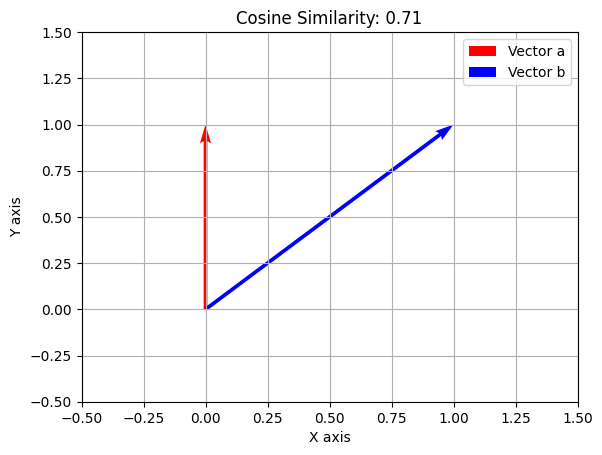

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 创建两个向量
a = np.array([0, 1])
b = np.array([1, 1])

# 计算两个向量的余弦相似度
cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 绘制向量
plt.quiver(0, 0, a[0], a[1], angles='xy', scale_units='xy', scale=1, color='r')
plt.quiver(0, 0, b[0], b[1], angles='xy', scale_units='xy', scale=1, color='b')

# 设置图表属性
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid()
plt.title(f'Cosine Similarity: {cosine_similarity:.2f}')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# 添加图例
plt.legend(['Vector a', 'Vector b'])

# 显示图表
plt.show()

这幅图展示了二维空间中两个向量的方向。红色向量代表$\vec{a}$ ，蓝色向量代表 $\vec{b}$  。它们之间的夹角表示了两个向量的余弦相似度。余弦相似度是通过计算两个向量的点积并除以它们各自的范数（即长度）来得到的。在这个示例中，这两个向量的余弦相似度大约为 0.71，意味着它们在方向上有一定程度的相似性。这个值越接近 1，表示两个向量的方向越相似。

- 余弦相似度计算函数

In [11]:
def cosine_sim(vector1: List[float], vector2: List[float]) -> float:
    """
    计算两个向量之间的余弦相似度
    """
    dot_product = np.dot(vector1, vector2)
    magnitude = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    if not magnitude:
        return 0
    return dot_product / magnitude

In [12]:
text1 = '我喜欢吃苹果'
text2 = "苹果是我最喜欢吃的水果"
text3 = "我喜欢用苹果手机"

In [13]:
vector1 = client.embeddings.create(
    input=text1,
    model="text-embedding-v4"
).data[0].embedding

vector2 = client.embeddings.create(
    input=text2,
    model="text-embedding-v4"
).data[0].embedding

vector3 = client.embeddings.create(
    input=text3,
    model="text-embedding-v4"
).data[0].embedding

In [14]:
cosine_sim(vector1, vector2)

np.float64(0.8391279496783216)

In [15]:
cosine_sim(vector1, vector3)

np.float64(0.7156295519936403)

In [16]:
cosine_sim(vector2, vector3)

np.float64(0.6863806867692233)

&emsp;&emsp;为了实现 RAG 模型的功能，我们首先需要一个向量化（Embedding）模块。向量化是 RAG 的基础，它的作用是将文档片段转化为向量表示，便于后续的检索操作。在这个过程中，我们将实现一个向量化类，用来将文本片段映射成向量。

&emsp;&emsp;为了便于扩展和未来可能使用不同的模型，我们首先编写一个 **Embedding 基类**。该基类定义了获取文本向量表示的方法，同时包含一个计算两个向量之间**余弦相似度**的功能。这样，如果我们未来使用不同的向量化模型，只需继承该基类并重写向量获取的逻辑，而不需要重复编写相似度计算部分。

In [17]:
class BaseEmbeddings:
    """
    向量化的基类，用于将文本转换为向量表示。不同的子类可以实现不同的向量获取方法。
    """
    def __init__(self, path: str, is_api: bool) -> None:
        """
        初始化基类。

        参数：
        path (str) - 如果是本地模型，path 表示模型路径；如果是API模式，path可以为空
        is_api (bool) - 表示是否使用API调用，如果为True表示通过API获取Embedding
        """
        self.path = path
        self.is_api = is_api

    def get_embedding(self, text: str, model: str) -> List[float]:
        """
        抽象方法，用于获取文本的向量表示，具体实现需要在子类中定义。

        参数：
        text (str) - 需要转换为向量的文本
        model (str) - 所使用的模型名称

        返回：
        list[float] - 文本的向量表示
        """
        raise NotImplementedError

    @classmethod
    def cosine_similarity(cls, vector1: List[float], vector2: List[float]) -> float:
        """
        计算两个向量之间的余弦相似度，用于衡量它们的相似程度。

        参数：
        vector1 (list[float]) - 第一个向量
        vector2 (list[float]) - 第二个向量

        返回：
        float - 余弦相似度值，范围从 -1 到 1，越接近 1 表示向量越相似
        """
        dot_product = np.dot(vector1, vector2)  # 向量点积
        magnitude = np.linalg.norm(vector1) * np.linalg.norm(vector2)  # 向量的模
        if not magnitude:
            return 0
        return dot_product / magnitude  # 计算余弦相似度


我们在这个基类基础上，可以通过继承它来实现具体的模型。例如，我们可以使用 OpenAI 的 API 来生成文本的向量表示，只需重写 `get_embedding` 方法即可。

In [22]:
class OpenAIEmbedding(BaseEmbeddings):
    """
    使用 OpenAI 的 Embedding API 来获取文本向量的类，继承自 BaseEmbeddings。
    """
    def __init__(self, path: str = '', is_api: bool = True) -> None:
        """
        初始化类，设置 OpenAI API 客户端，如果使用的是 API 调用。

        参数：
        path (str) - 本地模型的路径，使用API时可以为空
        is_api (bool) - 是否通过 API 获取 Embedding，默认为 True
        """
        super().__init__(path, is_api)
        if self.is_api:
            # 初始化 OpenAI API 客户端
            from openai import OpenAI
            self.client = OpenAI()
            self.client.api_key = os.getenv("OPENAI_API_KEY")  # 从环境变量中获取 API 密钥
            self.client.base_url = os.getenv("OPENAI_BASE_URL")  # 从环境变量中获取 API 基础URL

    def get_embedding(self, text: str, model: str = "text-embedding-v4") -> List[float]:
        """
        使用 OpenAI 的 Embedding API 获取文本的向量表示。

        参数：
        text (str) - 需要转化为向量的文本
        model (str) - 使用的 Embedding 模型名称，默认为 'text-embedding-v4'

        返回：
        list[float] - 文本的向量表示
        """
        if self.is_api:
            # 去掉文本中的换行符，保证输入格式规范
            text = text.replace("\n", " ")
            # 调用 OpenAI API 获取文本的向量表示
            return self.client.embeddings.create(input=[text], model=model).data[0].embedding
        else:
            raise NotImplementedError  # 如果不是 API 模式，这里未实现本地模型的处理


这样设计的结构让我们可以轻松替换或扩展向量化模型，而不需要改变整体框架。

- 使用示例

In [23]:
# 初始化 Embedding 模型
embedding_model = OpenAIEmbedding()

In [24]:
# 输入需要获取向量表示的文本
text = "这是一个示例文本，用于演示 OpenAI Embedding 的使用。"

# 获取文本的向量表示
embedding_vector = embedding_model.get_embedding(text, model="text-embedding-v4")

print("文本的向量表示为：", embedding_vector)

文本的向量表示为： [-0.06656274199485779, 0.019207844510674477, 0.018718861043453217, -0.010467281565070152, 0.0015166098019108176, -0.06589039415121078, 0.025396527722477913, 0.04183856397867203, -0.026557860895991325, 0.12420155107975006, -0.005890711210668087, -0.025472931563854218, 0.01387487817555666, -0.028605476021766663, -0.040982846170663834, -0.021438825875520706, 0.020766476169228554, -0.06194796785712242, 0.006070259027183056, 0.008862807415425777, -0.001338971545919776, -0.024479685351252556, 0.003035129513591528, -0.023822616785764694, -0.021056808531284332, 0.009710886515676975, 0.03051556460559368, -0.011292439885437489, 0.02055254578590393, -0.0163809135556221, -0.029002774506807327, 0.02854435332119465, 0.07823719829320908, 0.0112313162535429, 0.01830628141760826, 0.06809081137180328, -0.013783194124698639, 0.03786558285355568, -0.01259893923997879, -0.04682007431983948, -0.015846088528633118, 0.02726077474653721, -0.014340939931571484, 0.028299862518906593, 0.0051839784719049

In [25]:
vector1 = embedding_model.get_embedding(text1)
vector2 = embedding_model.get_embedding(text2)

In [26]:
similarity = BaseEmbeddings.cosine_similarity(vector1, vector2)

In [27]:
print(f"两段文本的余弦相似度为: {similarity}")

两段文本的余弦相似度为: 0.8391279496783216


### 3. 文档加载与切分模块创建

&emsp;&emsp;在实现了向量化之后，我们接下来需要编写一个**文档加载与切分模块**，用于处理不同格式的文档并将其切分为小片段。为什么要进行切分呢？这是为了确保每个文档片段都尽量保持简短且信息集中，以便于后续的向量化和检索。

#### 3.1 文档格式处理函数

&emsp;&emsp;我们的目标是支持多种格式的文档，例如 PDF、Markdown、TXT 等。每种文件格式都有不同的读取方式，下面我们展示一个支持多种格式的简单实现：

In [28]:
def read_file_content(cls, file_path: str):
    # 根据文件扩展名选择读取方法
    if file_path.endswith('.pdf'):
        return cls.read_pdf(file_path)
    elif file_path.endswith('.md'):
        return cls.read_markdown(file_path)
    elif file_path.endswith('.txt'):
        return cls.read_text(file_path)
    else:
        raise ValueError("Unsupported file type")

#### 3.2 文档切分函数

&emsp;&emsp;这里我们考虑将文档按**Token**长度进行切分，设置一个最大的 Token 长度，然后按这个长度进行切分。在这个过程中，我们也会确保每个片段之间有一定的重叠，避免重要信息被切掉。

<center><center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20231218182814731.png" alt="image-20231218182814731" style="zoom:33%;" /></center>

In [29]:
def get_chunk(cls, text: str, max_token_len: int = 600, cover_content: int = 150):
    chunk_text = []
    curr_len = 0
    curr_chunk = ''
    lines = text.split('\n')  # 以换行符为单位切分文本

    for line in lines:
        line = line.replace(' ', '')
        line_len = len(enc.encode(line))  # 计算当前行的 Token 长度
        if line_len > max_token_len:
            print('warning line_len = ', line_len)
        if curr_len + line_len <= max_token_len:
            curr_chunk += line + '\n'
            curr_len += line_len + 1
        else:
            chunk_text.append(curr_chunk)
            curr_chunk = curr_chunk[-cover_content:] + line
            curr_len = line_len + cover_content

    if curr_chunk:
        chunk_text.append(curr_chunk)

    return chunk_text

完整类编写如下：

In [30]:
enc = tiktoken.get_encoding("cl100k_base")

In [31]:
len(enc.encode("你好，好久不见！"))

9

In [32]:
class ReadFiles:
    """
    读取文件的类，用于从指定路径读取支持的文件类型（如 .txt、.md、.pdf）并进行内容分割。
    """

    def __init__(self, path: str) -> None:
        """
        初始化函数，设定要读取的文件路径，并获取该路径下所有符合要求的文件。
        :param path: 文件夹路径
        """
        self._path = path
        self.file_list = self.get_files()  # 获取文件列表

    def get_files(self):
        """
        遍历指定文件夹，获取支持的文件类型列表（txt, md, pdf）。
        :return: 文件路径列表
        """
        file_list = []
        for filepath, dirnames, filenames in os.walk(self._path):
            # os.walk 函数将递归遍历指定文件夹
            for filename in filenames:
                # 根据文件后缀筛选支持的文件类型
                if filename.endswith(".md"):
                    file_list.append(os.path.join(filepath, filename))
                elif filename.endswith(".txt"):
                    file_list.append(os.path.join(filepath, filename))
                elif filename.endswith(".pdf"):
                    file_list.append(os.path.join(filepath, filename))
        return file_list

    def get_content(self, max_token_len: int = 600, cover_content: int = 150):
        """
        读取文件内容并进行分割，将长文本切分为多个块。
        :param max_token_len: 每个文档片段的最大 Token 长度
        :param cover_content: 在每个片段之间重叠的 Token 长度
        :return: 切分后的文档片段列表
        """
        docs = []
        for file in self.file_list:
            content = self.read_file_content(file)  # 读取文件内容
            # 分割文档为多个小块
            chunk_content = self.get_chunk(content, max_token_len=max_token_len, cover_content=cover_content)
            docs.extend(chunk_content)
        return docs

    @classmethod
    def get_chunk(cls, text: str, max_token_len: int = 600, cover_content: int = 150):
        """
        将文档内容按最大 Token 长度进行切分。
        :param text: 文档内容
        :param max_token_len: 每个片段的最大 Token 长度
        :param cover_content: 重叠的内容长度
        :return: 切分后的文档片段列表
        """
        chunk_text = []
        curr_len = 0
        curr_chunk = ''
        token_len = max_token_len - cover_content
        lines = text.splitlines()  # 以换行符分割文本为行

        for line in lines:
            line = line.replace(' ', '')  # 去除空格
            line_len = len(enc.encode(line))  # 计算当前行的 Token 长度
            if line_len > max_token_len:
                # 如果单行长度超过限制，将其分割为多个片段
                num_chunks = (line_len + token_len - 1) // token_len
                for i in range(num_chunks):
                    start = i * token_len
                    end = start + token_len
                    # 防止跨单词分割
                    while not line[start:end].rstrip().isspace():
                        start += 1
                        end += 1
                        if start >= line_len:
                            break
                    curr_chunk = curr_chunk[-cover_content:] + line[start:end]
                    chunk_text.append(curr_chunk)
                start = (num_chunks - 1) * token_len
                curr_chunk = curr_chunk[-cover_content:] + line[start:end]
                chunk_text.append(curr_chunk)
            elif curr_len + line_len <= token_len:
                # 当前片段长度未超过限制时，继续累加
                curr_chunk += line + '\n'
                curr_len += line_len + 1
            else:
                chunk_text.append(curr_chunk)  # 保存当前片段
                curr_chunk = curr_chunk[-cover_content:] + line
                curr_len = line_len + cover_content

        if curr_chunk:
            chunk_text.append(curr_chunk)

        return chunk_text

    @classmethod
    def read_file_content(cls, file_path: str):
        """
        读取文件内容，根据文件类型选择不同的读取方式。
        :param file_path: 文件路径
        :return: 文件内容
        """
        if file_path.endswith('.pdf'):
            return cls.read_pdf(file_path)
        elif file_path.endswith('.md'):
            return cls.read_markdown(file_path)
        elif file_path.endswith('.txt'):
            return cls.read_text(file_path)
        else:
            raise ValueError("Unsupported file type")

    @classmethod
    def read_pdf(cls, file_path: str):
        """
        读取 PDF 文件内容。
        :param file_path: PDF 文件路径
        :return: PDF 文件中的文本内容
        """
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page_num in range(len(reader.pages)):
                text += reader.pages[page_num].extract_text()
            return text

    @classmethod
    def read_markdown(cls, file_path: str):
        """
        读取 Markdown 文件内容，并将其转换为纯文本。
        :param file_path: Markdown 文件路径
        :return: 纯文本内容
        """
        with open(file_path, 'r', encoding='utf-8') as file:
            md_text = file.read()
            html_text = markdown.markdown(md_text)
            # 使用 BeautifulSoup 从 HTML 中提取纯文本
            soup = BeautifulSoup(html_text, 'html.parser')
            plain_text = soup.get_text()
            # 使用正则表达式移除网址链接
            text = re.sub(r'http\S+', '', plain_text)
            return text

    @classmethod
    def read_text(cls, file_path: str):
        """
        读取普通文本文件内容。
        :param file_path: 文本文件路径
        :return: 文件内容
        """
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()

In [33]:
class Documents:
    """
    文档类，用于读取已分好类的 JSON 格式文档。
    """
    def __init__(self, path: str = '') -> None:
        self.path = path

    def get_content(self):
        """
        读取 JSON 格式的文档内容。
        :return: JSON 文档的内容
        """
        with open(self.path, mode='r', encoding='utf-8') as f:
            content = json.load(f)
        return content

In [35]:
# 初始化 ReadFiles 类，指定文件目录路径
file_reader = ReadFiles(path="./data")

# 获取目录下所有支持的文件类型
file_list = file_reader.get_files()
print("支持的文件列表：", file_list)

支持的文件列表： ['./data/模拟公司员工手册.md', './data/layout-parser-paper.pdf']


In [36]:
# 将文件内容读取并分块
document_chunks = file_reader.get_content(max_token_len=600, cover_content=150)
print("分块后的文档内容：", document_chunks)

分块后的文档内容： ['创新科技股份有限公司员工手册\n前言\n尊敬的员工：\n欢迎您加入创新科技股份有限公司（以下简称“公司”）。作为一家致力于推动科技创新的企业，我们深信每一位员工都是公司成功的关键。本员工手册是公司为所有员工提供的全面指导文件，旨在帮助您了解公司的核心价值观、行为准则、工作规范以及各项政策。通过本手册，您将更好地融入公司文化，并与公司共同实现卓越目标。\n本手册详细阐述了公司的政策、程序和期望，包括员工权利、义务、福利待遇以及纪律措施。公司保留随时修改本手册内容的权利，任何变更将通过电子邮件、内部通知系统或更新手册版本的形式及时告知所有员工。作为员工，您有责任定期审阅本手册，并确保您的行为符合其规定。如果您对任何内容有疑问，请随时联系人力资源部门，我们将提供必要的解释和支持。\n请注意，本手册并非正式的雇佣合同，而是作为指导性文件存在。它旨在促进公司与员工之间的互信与合作。公司相信，通过严格遵守这些准则，我们将共同营造一个高效、创新、和谐的工作环境，推动公司可持续发展。\n', '并确保您的行为符合其规定。如果您对任何内容有疑问，请随时联系人力资源部门，我们将提供必要的解释和支持。\n请注意，本手册并非正式的雇佣合同，而是作为指导性文件存在。它旨在促进公司与员工之间的互信与合作。公司相信，通过严格遵守这些准则，我们将共同营造一个高效、创新、和谐的工作环境，推动公司可持续发展。\n我们期待与您携手共进，共创辉煌。公司管理层\n2025年7月11日\n第一章：公司概述\n1.1公司使命与愿景\n创新科技股份有限公司成立于2010年，总部位于北京，是一家专注于人工智能、云计算、大数据和物联网解决方案的高科技企业。公司使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商，为客户提供高效、可靠的解决方案，推动社会进步。\n', '1日\n第一章：公司概述\n1.1公司使命与愿景\n创新科技股份有限公司成立于2010年，总部位于北京，是一家专注于人工智能、云计算、大数据和物联网解决方案的高科技企业。公司使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商，为客户提供高效、可靠的解决方案，推动社会进步。\n公司的核心价值观包括：创新（鼓励大胆尝试新想法）、诚信（以诚实为基础开展所有业务）、协作（强调

In [37]:
document_chunks[0]

'创新科技股份有限公司员工手册\n前言\n尊敬的员工：\n欢迎您加入创新科技股份有限公司（以下简称“公司”）。作为一家致力于推动科技创新的企业，我们深信每一位员工都是公司成功的关键。本员工手册是公司为所有员工提供的全面指导文件，旨在帮助您了解公司的核心价值观、行为准则、工作规范以及各项政策。通过本手册，您将更好地融入公司文化，并与公司共同实现卓越目标。\n本手册详细阐述了公司的政策、程序和期望，包括员工权利、义务、福利待遇以及纪律措施。公司保留随时修改本手册内容的权利，任何变更将通过电子邮件、内部通知系统或更新手册版本的形式及时告知所有员工。作为员工，您有责任定期审阅本手册，并确保您的行为符合其规定。如果您对任何内容有疑问，请随时联系人力资源部门，我们将提供必要的解释和支持。\n请注意，本手册并非正式的雇佣合同，而是作为指导性文件存在。它旨在促进公司与员工之间的互信与合作。公司相信，通过严格遵守这些准则，我们将共同营造一个高效、创新、和谐的工作环境，推动公司可持续发展。\n'

In [38]:
document_chunks[1]

'并确保您的行为符合其规定。如果您对任何内容有疑问，请随时联系人力资源部门，我们将提供必要的解释和支持。\n请注意，本手册并非正式的雇佣合同，而是作为指导性文件存在。它旨在促进公司与员工之间的互信与合作。公司相信，通过严格遵守这些准则，我们将共同营造一个高效、创新、和谐的工作环境，推动公司可持续发展。\n我们期待与您携手共进，共创辉煌。公司管理层\n2025年7月11日\n第一章：公司概述\n1.1公司使命与愿景\n创新科技股份有限公司成立于2010年，总部位于北京，是一家专注于人工智能、云计算、大数据和物联网解决方案的高科技企业。公司使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商，为客户提供高效、可靠的解决方案，推动社会进步。\n'

### 4. 词向量数据库与向量检索模块

&emsp;&emsp;接下来我们将继续构建**向量数据库**以及**检索模块**，这是 RAG 模型中的核心功能之一。向量数据库用于存储文档片段及其对应的向量表示，而检索模块则根据用户提出的问题（Query）在数据库中检索相关的文档片段。通过这些功能，我们创建的简易 RAG 能够根据输入的查询快速找到最相关的文档片段。

&emsp;&emsp;为了构建这个向量数据库，我们需要以下几个关键功能：

1. **持久化存储（persist）：** 将数据库存储到本地，便于下次加载使用。
2. **加载数据库（load_vector）：** 从本地文件加载已经存储的向量和文档。
3. **获取向量表示（get_vector）：** 将文档转化为向量表示并存储。
4. **检索（query）：** 根据用户的 Query，检索数据库中的相关文档片段。

我们将基于这些功能来实现一个简单的 `VectorStore` 类。

&emsp;&emsp;首先，我们创建一个基础的 `VectorStore` 类，提供上述功能的框架。通过这个类，我们能够将文档片段转化为向量存储，加载本地数据库，进行检索。

In [39]:
class VectorStore:
    def __init__(self, document: List[str] = None) -> None:
        """
        初始化向量存储类，存储文档和对应的向量表示。
        :param document: 文档列表，默认为空。
        """
        if document is None:
            document = []
        self.document = document  # 存储文档内容
        self.vectors = []  # 存储文档的向量表示

    def get_vector(self, EmbeddingModel: BaseEmbeddings) -> List[List[float]]:
        """
        使用传入的 Embedding 模型将文档向量化。
        :param EmbeddingModel: 传入的用于生成向量的模型（需继承 BaseEmbeddings 类）。
        :return: 返回文档对应的向量列表。
        """
        # 遍历所有文档，获取每个文档的向量表示
        self.vectors = [EmbeddingModel.get_embedding(doc) for doc in self.document]
        return self.vectors

    def persist(self, path: str = 'storage'):
        """
        将文档和对应的向量表示持久化到本地目录中，以便后续加载使用。
        :param path: 存储路径，默认为 'storage'。
        """
        if not os.path.exists(path):
            os.makedirs(path)  # 如果路径不存在，创建路径
        # 保存向量为 numpy 文件
        np.save(os.path.join(path, 'vectors.npy'), self.vectors)
        # 将文档内容存储到文本文件中
        with open(os.path.join(path, 'documents.txt'), 'w') as f:
            for doc in self.document:
                f.write(f"{doc}\n")

    def load_vector(self, path: str = 'storage'):
        """
        从本地加载之前保存的文档和向量数据。
        :param path: 存储路径，默认为 'storage'。
        """
        # 加载保存的向量数据
        self.vectors = np.load(os.path.join(path, 'vectors.npy')).tolist()
        # 加载文档内容
        with open(os.path.join(path, 'documents.txt'), 'r') as f:
            self.document = [line.strip() for line in f.readlines()]

    def get_similarity(self, vector1: List[float], vector2: List[float]) -> float:
        """
        计算两个向量的余弦相似度。
        :param vector1: 第一个向量。
        :param vector2: 第二个向量。
        :return: 返回两个向量的余弦相似度，范围从 -1 到 1。
        """
        dot_product = np.dot(vector1, vector2)
        magnitude = np.linalg.norm(vector1) * np.linalg.norm(vector2)
        if not magnitude:
            return 0
        return dot_product / magnitude

    def query(self, query: str, EmbeddingModel: BaseEmbeddings, k: int = 1) -> List[str]:
        """
        根据用户的查询文本，检索最相关的文档片段。
        :param query: 用户的查询文本。
        :param EmbeddingModel: 用于将查询向量化的嵌入模型。
        :param k: 返回最相似的文档数量，默认为 1。
        :return: 返回最相似的文档列表。
        """
        # 将查询文本向量化
        query_vector = EmbeddingModel.get_embedding(query)
        # 计算查询向量与每个文档向量的相似度
        similarities = [self.get_similarity(query_vector, vector) for vector in self.vectors]
        # 获取相似度最高的 k 个文档索引
        top_k_indices = np.argsort(similarities)[-k:][::-1]
        # 返回对应的文档内容
        return [self.document[idx] for idx in top_k_indices]

上述代码解释如下：
- **get_vector 方法：** 这个方法使用传入的 `EmbeddingModel` 对所有文档进行向量化，并将这些向量存储在 `self.vectors` 中。
- **persist 方法：** 该方法将文档片段及其向量表示保存到本地文件系统，便于持久化存储。
- **load_vector 方法：** 从本地文件系统加载已保存的文档片段和向量，供后续检索使用。
- **get_similarity 方法：** 计算两个向量之间的余弦相似度，用于比较查询和文档向量的相似度。
- **query 方法：** 接收用户输入的查询，通过向量化后在数据库中检索最相关的文档片段，并返回最匹配的文档。

假设我们已经有一组文档片段存储在 `documents` 中，并且使用 qianwen 的 Embedding API 进行向量化处理，以下是一个简化的运行示例：

In [40]:
# 初始化文档列表
documents = [
    "机器学习是人工智能的一个分支。",
    "深度学习是一种特殊的机器学习方法。",
    "监督学习是一种训练模型的方式。",
    "强化学习通过奖励和惩罚进行学习。",
    "无监督学习不依赖标签数据。",
]

In [41]:
# 创建向量数据库
vector_store = VectorStore(document=documents)

# 使用 OpenAI Embedding 模型对文档进行向量化
embedding_model = OpenAIEmbedding()

# 获取文档向量并存储
vector_store.get_vector(embedding_model)

# 持久化存储到本地
vector_store.persist('storage')

In [42]:
# 模拟用户查询
query = "什么是深度学习？"
result = vector_store.query(query, embedding_model)

print("检索结果：", result)

检索结果： ['深度学习是一种特殊的机器学习方法。']


在上面这段代码中，npy 文件是 NumPy 库用于存储数组数据的文件格式。npy 文件能够高效地保存和加载 NumPy 数组，并保留数组的形状、数据类型等信息。它是一种二进制文件格式，用于序列化 NumPy 数组，使得存储和读取过程更加快速和便捷。

In [43]:
loaded_array = np.load('./storage/vectors.npy')

print(loaded_array)

[[-0.06664975  0.05799633  0.03268047 ...  0.02327908 -0.0576281
  -0.01857264]
 [-0.07242706  0.04455362  0.01508897 ... -0.00161692  0.01460887
  -0.0109738 ]
 [-0.0867338   0.02599478  0.07450991 ... -0.00947858 -0.03542898
  -0.01704243]
 [-0.03096011 -0.02173997  0.02832578 ... -0.01291362 -0.00115252
   0.00954603]
 [-0.05671316  0.00286942  0.04257988 ...  0.00241368 -0.04531051
   0.0189494 ]]


### 5. 大模型问答模块编写

&emsp;&emsp;现在我们已经构建了向量数据库和检索模块，接下来我们将实现大模型模块，用于根据检索到的相关文档片段生成对用户问题的回答。为了简化和便于扩展，我们会先实现一个基类 `BaseModel`，然后再以 **qianwen-plus** 模型为例，展示如何使用大语言模型来完成这个任务。

#### 5.1 大模型模块的基类

&emsp;&emsp;这里我们先编写一个基类 `BaseModel`，它包含两个主要方法：
- `chat`：负责处理用户的输入并生成回答。
- `load_model`：如果是使用本地模型，这个方法负责加载模型。如果使用 API 模型（如 OpenAI），可以不用实现这个方法。

In [44]:
class BaseModel:
    """
    基础模型类，作为所有模型的基类。
    包含一些通用的接口，如加载模型、生成回答等。
    """
    def __init__(self, path: str = '') -> None:
        self.path = path  # 用于存储模型文件的路径，默认为空。

    def chat(self, prompt: str, history: List[dict], content: str) -> str:
        """
        使用模型生成回答的抽象方法。
        :param prompt: 用户的提问内容
        :param history: 之前的对话历史（字典列表）
        :param content: 提供的上下文内容
        :return: 模型生成的答案
        """
        pass  # 具体的实现由子类提供

    def load_model(self):
        """
        加载模型的方法，通常用于本地模型。
        """
        pass  # 如果是 API 模型，可能不需要实现

#### 5.2 借助qianwen-plus模型进行对话

In [56]:
class QianChat(BaseModel):
    """
    基于 qianwen-plus 模型的对话类，继承自 BaseModel。
    主要用于通过 OpenAI API 来生成对话回答。
    """
    def __init__(self, api_key: str, base_url: str = "https://dashscope.aliyuncs.com/compatible-mode/v1") -> None:
        """
        初始化 qianwen-plus 模型。
        :param api_key: OpenAI API 的密钥
        :param base_url: 用于访问 OpenAI API 的基础 URL，默认为代理 URL
        """
        super().__init__()
        self.client = OpenAI(api_key=api_key, base_url=base_url)  # 初始化 OpenAI 客户端

    def chat(self, prompt: str, history: List = [], content: str = '') -> str:
        """
        使用 qianwen-plus生成回答。
        :param prompt: 用户的提问
        :param history: 之前的对话历史（可选）
        :param content: 可参考的上下文信息（可选）
        :return: 生成的回答
        """
        # 构建包含问题和上下文的完整提示
        full_prompt = PROMPT_TEMPLATE['Qwen_PROMPT_TEMPLATE'].format(question=prompt, context=content)

        # 调用 qianwen-plus 模型进行推理
        response = self.client.chat.completions.create(
            model="qwen-plus",  # 使用 GPT-4o 小型模型
            messages=[
                {"role": "user", "content": full_prompt}
            ]
        )

        # 返回模型生成的第一个回答
        return response.choices[0].message.content

#### 5.3 提示模板

&emsp;&emsp;为了方便维护和复用提示语，可以使用一个字典来保存不同模型的提示模板。在这里我们为 `GPT4o` 定义了一个模板：

In [57]:
PROMPT_TEMPLATE = dict(
    Qwen_PROMPT_TEMPLATE="""
    下面有一个或许与这个问题相关的参考段落，若你觉得参考段落能和问题相关，则先总结参考段落的内容。
    若你觉得参考段落和问题无关，则使用你自己的原始知识来回答用户的问题，并且总是使用中文来进行回答。
    问题: {question}
    可参考的上下文：
    ···
    {context}
    ···
    有用的回答:"""
)

### 6. 体验课RAG Demo完整流程演示

&emsp;&emsp;接下来，我们展示一个完整的 RAG Demo，结合我们前面实现的向量检索和大模型模块，展示如何在实际应用中使用 RAG 模型来回答问题。

In [47]:
# 加载并切分文档
docs = ReadFiles('./data').get_content(max_token_len=600, cover_content=150)
vector = VectorStore(docs)

In [48]:
# 使用 OpenAI Embedding 模型进行向量化
embedding = OpenAIEmbedding()
vector.get_vector(EmbeddingModel=embedding)

[[-0.03179723396897316,
  0.00016472625429742038,
  0.08193189650774002,
  -0.013043039478361607,
  -0.005213357042521238,
  0.0435899943113327,
  0.016963670030236244,
  0.07557245343923569,
  -0.0561545304954052,
  0.11416132748126984,
  0.017720011994242668,
  0.07223837077617645,
  -0.01978837512433529,
  0.033124689012765884,
  0.0288490429520607,
  -0.04241689294576645,
  0.0013207042356953025,
  -0.007856694981455803,
  -0.0025449362583458424,
  0.024465346708893776,
  0.0127960704267025,
  0.03874323144555092,
  0.0764368399977684,
  0.04152162745594978,
  0.045905325561761856,
  0.01930987276136875,
  -0.017720011994242668,
  -0.020591024309396744,
  0.030685873702168465,
  -0.004781161434948444,
  0.021779561415314674,
  -0.06699028611183167,
  0.00798017904162407,
  0.001607226673513651,
  0.034884341061115265,
  0.02108496055006981,
  -0.032908592373132706,
  -0.007567278575152159,
  -0.017102589830756187,
  -0.03942239284515381,
  -0.02475862205028534,
  -0.001666074618697

In [49]:
# 将向量和文档保存到本地
vector.persist(path='storage')

In [51]:
# 用户提出问题
question = '创新科技股份有限公司的介绍'

In [52]:
# 在数据库中检索最相关的文档片段
content = vector.query(question, EmbeddingModel=embedding, k=1)[0]

In [53]:
content

'1日\n第一章：公司概述\n1.1公司使命与愿景\n创新科技股份有限公司成立于2010年，总部位于北京，是一家专注于人工智能、云计算、大数据和物联网解决方案的高科技企业。公司使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商，为客户提供高效、可靠的解决方案，推动社会进步。\n公司的核心价值观包括：创新（鼓励大胆尝试新想法）、诚信（以诚实为基础开展所有业务）、协作（强调团队合作与跨部门沟通）、卓越（追求最高标准的工作质量）和责任（对员工、客户和社会承担义务）。这些价值观不仅仅是口号，而是渗透到公司日常运营的每一个环节。例如，在项目开发中，我们优先考虑可持续性和伦理因素，确保技术应用符合社会责任。'

In [ ]:
# 使用 QianChat 模型生成答案
chat = QianChat(api_key = os.getenv("sk-XXXXX(自己的API-KEY)"))  # 传入 OpenAI API 密钥
print(chat.chat(question, [], content))

创新科技股份有限公司成立于2010年，总部位于北京，是一家专注于人工智能、云计算、大数据和物联网解决方案的高科技企业。公司的使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商。其核心价值观包括创新、诚信、协作、卓越和责任，并贯穿于公司各项业务和运营活动中，强调可持续性与社会责任。


- 完整函数封装

In [60]:
def run_mini_rag(question: str, knowledge_base_path: str, k: int = 1) -> str:
    """
    运行一个简化版的RAG项目。

    :param question: 用户提出的问题
    :param knowledge_base_path: 知识库的路径，包含文档的文件夹路径
    :param api_key: OpenAI API密钥，用于调用GPT-4o模型
    :param k: 返回与问题最相关的k个文档片段，默认为1
    :return: 返回GPT-4o模型生成的回答
    """
    api_key = os.getenv("Qwen_PROMPT_TEMPLATE")
    # 1. 加载并切分文档
    docs = ReadFiles(knowledge_base_path).get_content(max_token_len=600, cover_content=150)
    vector = VectorStore(docs)

    # 2. 使用 OpenAI Embedding 模型进行向量化
    embedding = OpenAIEmbedding()
    vector.get_vector(EmbeddingModel=embedding)

    # 3. 将向量和文档保存到本地（可选）
    vector.persist(path='storage')

    # 4. 在数据库中检索最相关的文档片段
    content = vector.query(question, EmbeddingModel=embedding, k=k)[0]

    # 5. 使用 GPT-4o 生成答案
    chat = QianChat(api_key=api_key)
    answer = chat.chat(question, [], content)

    return answer

In [61]:
question = '请问我应该如何面试创新科技股份有限公司？'

In [62]:
knowledge_base_path = './data'

In [63]:
answer = run_mini_rag(question, knowledge_base_path)

In [64]:
display(Markdown(answer))

### 参考段落总结：
上述段落来自创新科技股份有限公司的员工手册或类似内部文件，主要内容包括：
1. **公司概述**：公司成立于2010年，总部位于北京，专注于人工智能、云计算、大数据和物联网领域。
2. **使命与愿景**：使命是“通过前沿技术创新，驱动全球数字化转型”，愿景是成为世界领先的科技服务提供商。
3. 强调了员工与公司之间的互信合作，营造高效、创新、和谐的工作环境。

---

### 如何面试创新科技股份有限公司的建议：

如果你计划面试**创新科技股份有限公司**，可以参考以下建议，结合其公司特点和文化：

#### 1. **了解公司业务与技术方向**
- 公司聚焦于人工智能、云计算、大数据和物联网，建议你重点准备相关领域的知识。
- 关注其官网或技术博客，了解最新产品、技术应用案例，以及行业动态。

#### 2. **熟悉岗位要求**
- 仔细阅读招聘岗位的JD（职位描述），准备与岗位相关的技术问题或项目经验。
- 若是技术类岗位，可能会涉及算法、编程能力、系统设计等；若是产品或运营类岗位，则关注数据分析、市场理解、项目管理等能力。

#### 3. **准备技术或案例面试**
- 技术面试中可能会有编程题、系统设计题或算法题，建议多刷LeetCode、牛客网等平台题目。
- 非技术岗位可能需要准备产品设计、业务分析或解决问题的案例。

#### 4. **展现创新能力与团队协作能力**
- 公司强调“创新”与“合作”，在面试中可通过举例说明你在以往项目中如何提出创新想法，或如何与团队协作解决问题。
- 展现你对技术趋势的理解与热情，尤其是AI、大数据等前沿领域。

#### 5. **准备行为面试问题**
- 常见问题如“你遇到过的最大挑战是什么？”、“你如何处理团队中的分歧？”等。
- 回答时使用STAR法则（情境、任务、行动、结果），结构清晰，突出你的能力和价值观。

#### 6. **了解公司文化**
- 公司倡导“高效、创新、和谐”，在面试中展示你与公司文化的契合度。
- 表达你愿意与公司共同成长、推动数字化转型的意愿。

---

祝你面试顺利！如果你有具体的岗位方向，我可以提供更针对性的准备建议。